## Load necessary libraries

In [ ]:
import re
import pandas as pd 
pd.set_option('display.max_columns', None) 
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

## Working directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# File path set and defined to Google Drive to access all the datasets.
file_path = '/content/drive/MyDrive/IST340_Spring_Lab/'

## Load data

### Load the raw files

In [60]:
# Define a function for reading prolog files
def read_prolog_file(filename):
    with open(filename, 'r') as f:
        content = f.readlines()
    return content

In [61]:
# Read the male.pl and extract StudentID and Gender
content6 = read_prolog_file(file_path + 'male.pl')

facts = []
for line in content6:
    match = re.match(r'male\(student(\d+)\)\.', line.strip())
    if match:
        studentid = match.groups()
        facts.append([studentid[0], '1']) # Male = 1
        
df6 = pd.DataFrame(facts, columns=['StudentID', 'Gender'])
display(df6.head(), df6.shape, df6.dtypes)

,StudentID,Gender
0,997,1
1,994,1
2,992,1
3,987,1
4,986,1


(497, 2)

StudentID    object
Gender       object
dtype: object

In [62]:
# Change the data type of StudentID to int
df6[['StudentID', 'Gender']] = df6[['StudentID', 'Gender']].astype(int)
df6.dtypes

StudentID    int64
Gender       int64
dtype: object

In [63]:
# Read Region, Marital Status Excel file to get Country, Region, and Married fields
df7 = pd.read_excel(file_path + 'Region, Marital Status.xlsx')
df7.columns = ['StudentID', 'Country', 'Region', 'Marital_Status']
display(df7.head(), df7.shape, df7.dtypes)

,StudentID,Country,Region,Marital_Status
0,1,USA,2,1
1,2,USA,5,0
2,3,USA,2,1
3,4,USA,1,0
4,5,USA,3,0


(1000, 4)

StudentID          int64
Country           object
Region             int64
Marital_Status     int64
dtype: object

In [64]:
# Read longest_absense_from_school pl file to get the longest absence from school (in months)
content8 = read_prolog_file(file_path + 'longest_absense_from_school.pl')

facts = []
for line in content8:
    match = re.match(r'longest_absense_from_school\(student(\d+),(.+)\)\.', line.strip())
    if match:
        studentid, number_of_months = match.groups()
        facts.append([studentid, number_of_months])
        
df8 = pd.DataFrame(facts, columns=['StudentID', 'Longest_Absence_From_School'])
display(df8.head(), df8.shape, df8.dtypes)

,StudentID,Longest_Absence_From_School
0,1000,7
1,999,4
2,998,1
3,997,8
4,996,7


(1000, 2)

StudentID                      object
Longest_Absence_From_School    object
dtype: object

In [65]:
# Change the data types of StudentID and Longest_Absence_From_School to int
df8[['StudentID','Longest_Absence_From_School']] = df8[['StudentID', 'Longest_Absence_From_School']].astype(int)
df8.dtypes

StudentID                      int64
Longest_Absence_From_School    int64
dtype: object

In [66]:
# Read Filed_for_Bankruptcy pl file to get those students who have filed for bankruptcy
content9 = read_prolog_file(file_path + 'filed_for_bankrupcy.pl')

facts = []
for line in content9:
    match = re.match(r'filed_for_bankrupcy\(student(\d+)\)\.', line.strip())
    if match:
        studentid = match.groups()
        facts.append([studentid[0], '1']) # For those who have Filed, set = 1

df9 = pd.DataFrame(facts, columns=['StudentID', 'Filed_for_Bankrupcy'])
display(df9.head(), df9.shape, df9.dtypes)

,StudentID,Filed_for_Bankrupcy
0,999,1
1,998,1
2,958,1
3,956,1
4,953,1


(96, 2)

StudentID              object
Filed_for_Bankrupcy    object
dtype: object

In [67]:
# Change the data types of StudentID and Filed_for_Bankrupcy to int
df9[['StudentID', 'Filed_for_Bankrupcy']] = df9[['StudentID', 'Filed_for_Bankrupcy']].astype(int)
df9.dtypes

StudentID              int64
Filed_for_Bankrupcy    int64
dtype: object

In [68]:
# Read Personality Characteristics Data Excel file to get LongTermPlannerScore, DecisionStyle, PowerOrientedScore, CommunityOrientedScore fields
df10 = pd.read_excel(file_path + 'Personality Characteristics Data.xlsx')
df10.columns = ['StudentID', 'LongTermPlannerScore', 'DecisionStyle', 'PowerOrientedScore', 'CommunityOrientedScore']
display(df10.head(), df10.shape, df10.dtypes)

,StudentID,LongTermPlannerScore,DecisionStyle,PowerOrientedScore,CommunityOrientedScore
0,1,0.956004,Emotional,0.767967,0.189491
1,2,0.601589,Analytical,1.000000,0.529815
2,3,0.655254,Emotional,0.589539,0.589539
3,4,0.841278,Emotional,0.805702,0.061538
4,5,0.738851,Emotional,0.415433,0.241257


(1000, 5)

StudentID                   int64
LongTermPlannerScore      float64
DecisionStyle              object
PowerOrientedScore        float64
CommunityOrientedScore    float64
dtype: object

### Describe the data

In [69]:
# Create a metadata function that pulls of description of an input dataframe
def metadata(df):
    columns_list = list(df.columns.values)
    metadata = pd.DataFrame(columns_list, columns=['col_name'])

    # Data types
    metadata['data_type'] = [i for i in df.dtypes.astype(str)]

    # Missing values
    metadata['missing_values'] = [i for i in df.isnull().sum()]

    # Missing values percentage in two digits number
    metadata['missing_values_percentage'] = [round(i*100,2) for i in df.isnull().sum() / df.shape[0]]
    
    # Number of unique values
    metadata['unique_values'] = [i for i in df.nunique()]

    # Number of unique values percentage
    metadata['unique_values_percentage'] = [round(i*100,2) for i in df.nunique() / df.shape[0]]

    # Basic statistics for interval columns
    interval_columns = [col for col in columns_list if df[col].dtype != 'object']
    desc_interval = df[interval_columns].agg(['min', 'max', 'std']).transpose().reset_index().rename(columns={'index': 'col_name'})
    metadata = metadata.merge(desc_interval, on='col_name', how='left')

    return metadata

In [70]:
# Describe df6 df7 df8 df9 df10 by usng metadata function
display(metadata(df6), metadata(df7), metadata(df8), metadata(df9), metadata(df10))

,col_name,data_type,missing_values,missing_values_percentage,unique_values,unique_values_percentage,min,max,std
0,StudentID,int64,0,0.0,497,100.0,1.0,997.0,287.532835
1,Gender,int64,0,0.0,1,0.2,1.0,1.0,0.000000


,col_name,data_type,missing_values,missing_values_percentage,unique_values,unique_values_percentage,min,max,std
0,StudentID,int64,0,0.0,1000,100.0,1.0,1000.0,288.819436
1,Country,object,0,0.0,2,0.2,NaN,NaN,NaN
2,Region,int64,0,0.0,5,0.5,1.0,5.0,1.398838
3,Marital_Status,int64,0,0.0,3,0.3,0.0,2.0,0.500041


,col_name,data_type,missing_values,missing_values_percentage,unique_values,unique_values_percentage,min,max,std
0,StudentID,int64,0,0.0,1000,100.0,1.0,1000.0,288.819436
1,Longest_Absence_From_School,int64,0,0.0,10,1.0,0.0,9.0,2.802627


,col_name,data_type,missing_values,missing_values_percentage,unique_values,unique_values_percentage,min,max,std
0,StudentID,int64,0,0.0,96,100.00,2.0,999.0,284.657208
1,Filed_for_Bankrupcy,int64,0,0.0,1,1.04,1.0,1.0,0.000000


,col_name,data_type,missing_values,missing_values_percentage,unique_values,unique_values_percentage,min,max,std
0,StudentID,int64,0,0.0,1000,100.0,1.000000,1000.000000,288.819436
1,LongTermPlannerScore,float64,0,0.0,1000,100.0,0.090978,0.996835,0.171058
2,DecisionStyle,object,0,0.0,2,0.2,NaN,NaN,NaN
3,PowerOrientedScore,float64,0,0.0,960,96.0,0.076820,1.000000,0.202225
4,CommunityOrientedScore,float64,0,0.0,1000,100.0,0.000108,0.932651,0.211015


1. All dfs are have a unique value percentage of 100. Thus, we can conlude that there are no duplicate values and fields with 1-to-Many relationships. We can also conclude that there are no missing values.

2. In df7, Marital_Status has 3 unique values and a max value of 2. Per the Project Description document, 0 = not married, and 1 = married, so what does 2 stand for?

3. df6 (male.pl) only identifies 497 students as male, so we will have to do a left join on StudentID with this dataset to line up all male students and label all other records as female.

4. df8 (file_for_bankrupcy.pl) only identifies those 96 students who have filed for bankrupcy, so we'll so have to perform a left join on StudentID with this dataset to line up these students and label all other students as NOT filed for bankrupcy.

### Data Exploration

In [71]:
# Create a function that will perform exploratory data analysis on a specified column in a DataFrame, displaying basic statistics and visualizations.
def data_exploration(df, column):
    col_type = df[column].dtype

    if col_type == 'object' or col_type == 'category': 
        unique_values = df[column].nunique()
        print(f"Counts and percentages of unique values in {column}:\n")
        count_pct = pd.concat([df[column].value_counts(), df[column].value_counts(normalize=True) * 100], axis=1)
        count_pct.columns = ['Count', 'Percentage']
        print(count_pct)
        if unique_values < 10:   
            plt.figure(figsize=(8, 6))
            sns.countplot(data=df, x=column)
            plt.title(f"Bar chart of {column}") # Bar plot
            plt.show()
        else:
            bins_num = df[column].nunique()
            sns.histplot(data=df, x=column, bins=bins_num, kde=True) # Histogram
            plt.title(f"Histogram of {column}")
            plt.xticks(rotation=90, fontsize=7, ha="center")
            plt.show()
    
    else:
        mean = df[column].mean() # mean
        std_dev = df[column].std() # standard deviation
        # Calculate interquartile range (IQR)
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1 # interquartile range
        outlier_range = (q1 - 1.5*iqr, q3 + 1.5*iqr) # outlier range
        outliers = df[(df[column] < outlier_range[0]) | (df[column] > outlier_range[1])]
        outliers = outliers[column].values # outlier values

        print(f"Mean of {column}: {mean:.2f}")
        print(f"Standard deviation of {column}: {std_dev:.2f}")
        print(f"Number of outliers in {column}: {len(outliers)}")
        print("Outliers values:")
        print(outliers)

        plt.figure(figsize=(8, 6))
        sns.boxplot(data=df, x=column)
        plt.title(f"Box plot of {column}") # Box plot
        plt.show()

        if df[column].nunique() >= 10:
            plt.figure(figsize=(8, 6))
            sns.histplot(data=df, x=column, bins=10, kde=True) # Histogram that has 10 bins
            plt.title(f"Histogram of {column}")
            plt.show()
        else:
            plt.figure(figsize=(8, 6))
            sns.histplot(data=df, x=column, kde=True) # Histogram
            plt.title(f"Histogram of {column}")
            plt.show()

Mean of Gender: 1.00
Standard deviation of Gender: 0.00
Number of outliers in Gender: 0
Outliers values:
[]


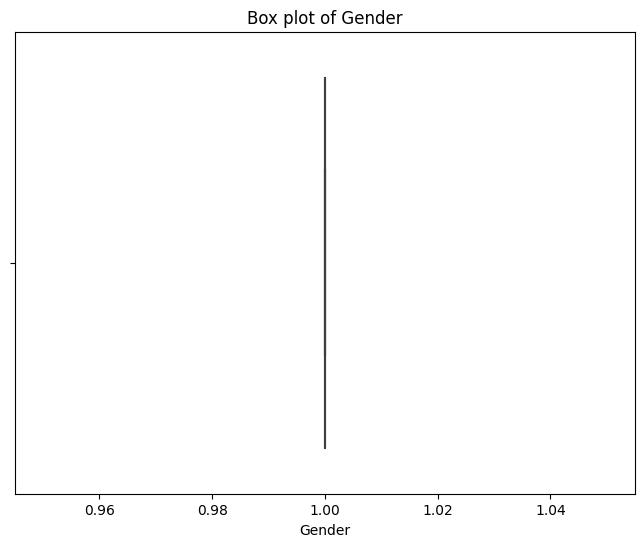

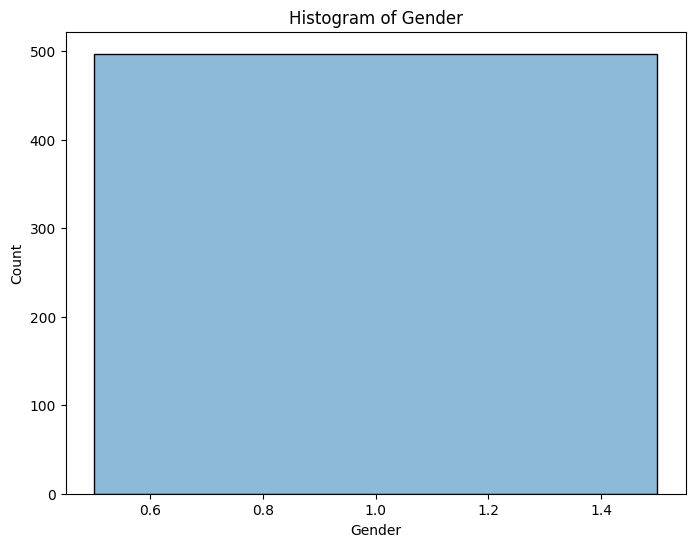

In [72]:
# Perform data exploration on df6 df7 df8 df9 df10
data_exploration(df6, 'Gender') # Obviously, these are all male, so we can assume all other students are female.

Counts and percentages of unique values in Country:

        Count  Percentage
USA       999        99.9
Belize      1         0.1


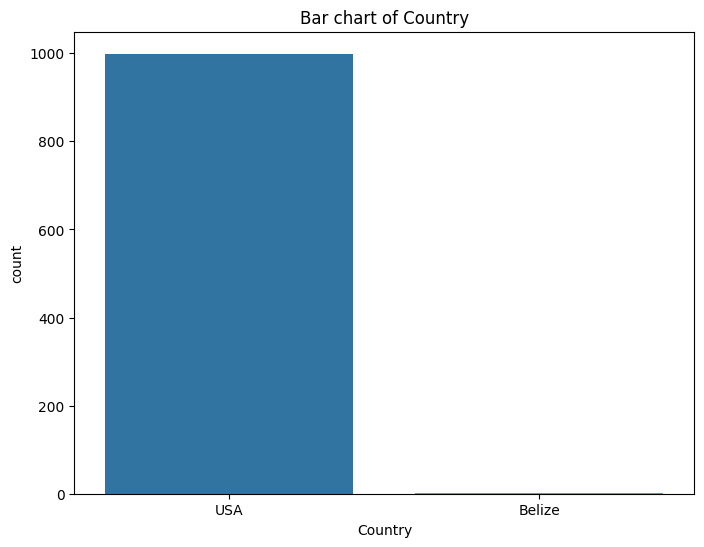

In [73]:
data_exploration(df7, 'Country') # 999 students are from the US, and 1 student is from Belize.

Mean of Region: 3.05
Standard deviation of Region: 1.40
Number of outliers in Region: 0
Outliers values:
[]


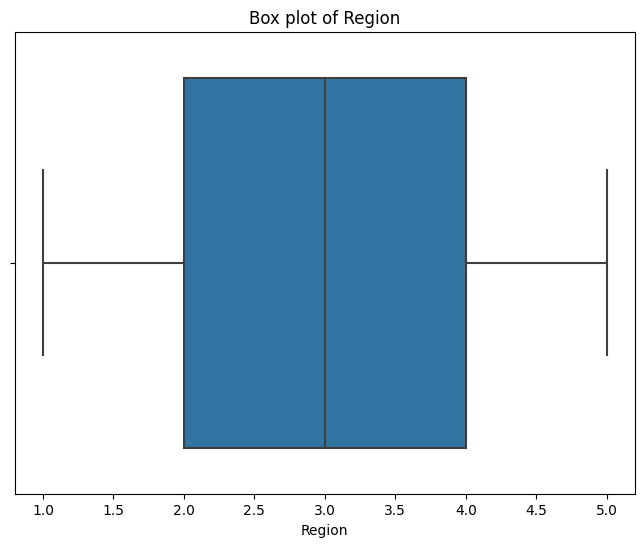

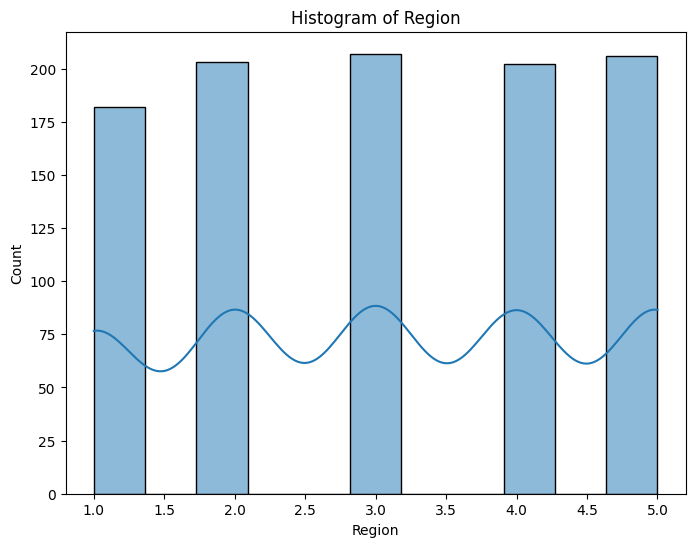

In [74]:
data_exploration(df7, 'Region') # Out Regions 1-5, most students are from regions 2, 3, and 4.

In [75]:
df7['Region'].value_counts()

3    207
5    206
2    203
4    202
1    182
Name: Region, dtype: int64

Mean of Marital_Status: 0.55
Standard deviation of Marital_Status: 0.50
Number of outliers in Marital_Status: 0
Outliers values:
[]


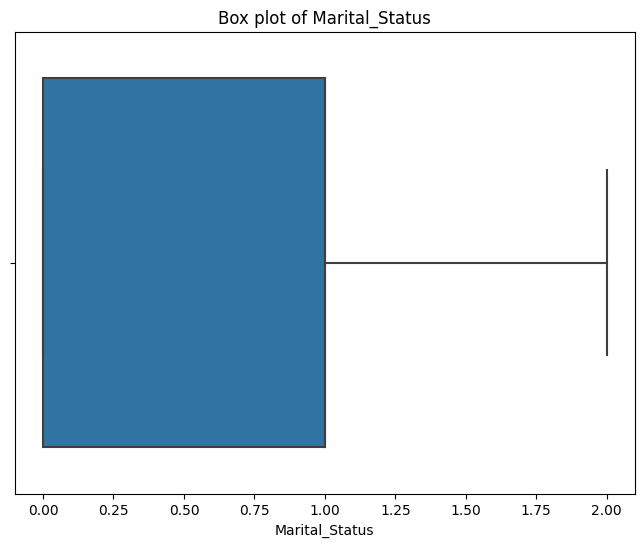

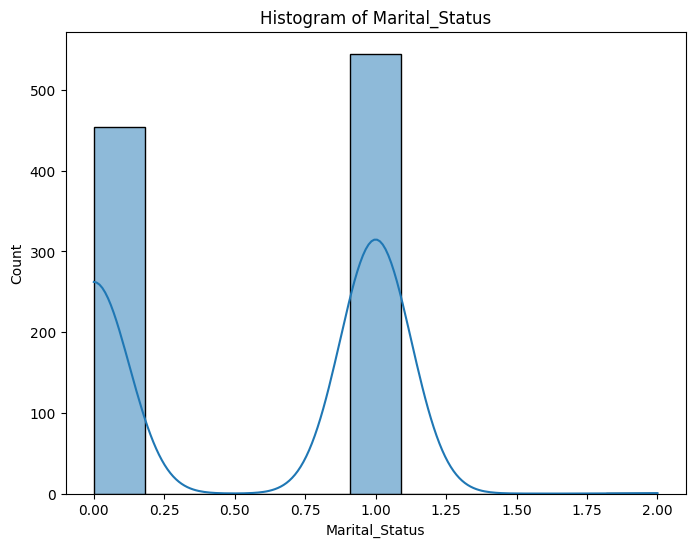

In [76]:
data_exploration(df7, 'Marital_Status')

In [77]:
df7['Marital_Status'].value_counts() # There are 545 students who are married (labeled as 1), and 454 students who are not married (labeled as 0). What does 2 stand for?

1    545
0    454
2      1
Name: Marital_Status, dtype: int64

Mean of Longest_Absence_From_School: 4.44
Standard deviation of Longest_Absence_From_School: 2.80
Number of outliers in Longest_Absence_From_School: 0
Outliers values:
[]


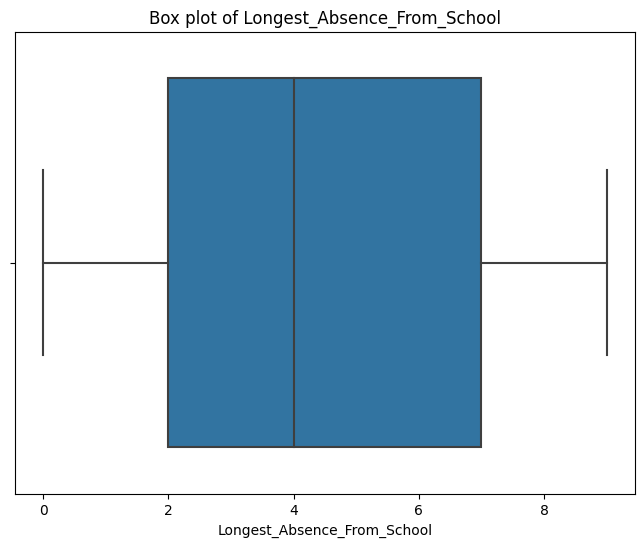

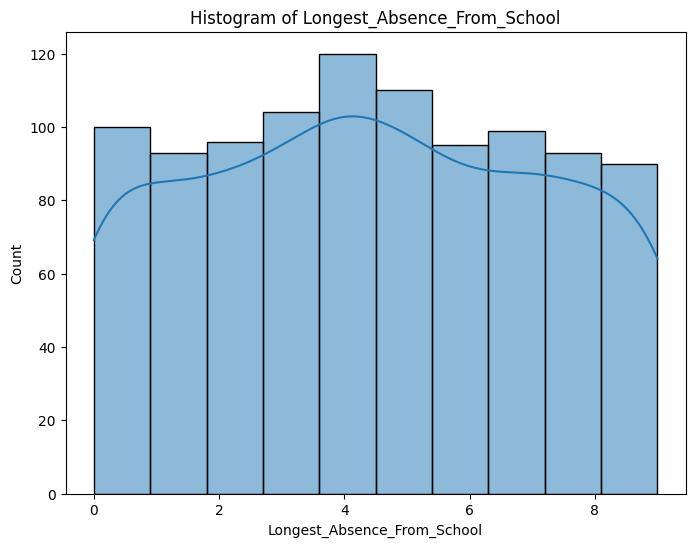

In [78]:
data_exploration(df8, 'Longest_Absence_From_School')

In [79]:
df8['Longest_Absence_From_School'].value_counts() # Most students longest absence ranges from 2-7 months.  The highest is 4 months and lowest is 9 months.

4    120
5    110
3    104
0    100
7     99
2     96
6     95
1     93
8     93
9     90
Name: Longest_Absence_From_School, dtype: int64

Mean of Filed_for_Bankrupcy: 1.00
Standard deviation of Filed_for_Bankrupcy: 0.00
Number of outliers in Filed_for_Bankrupcy: 0
Outliers values:
[]


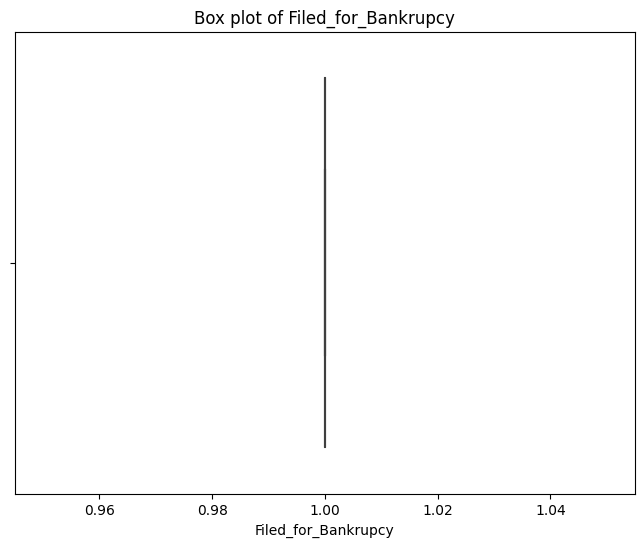

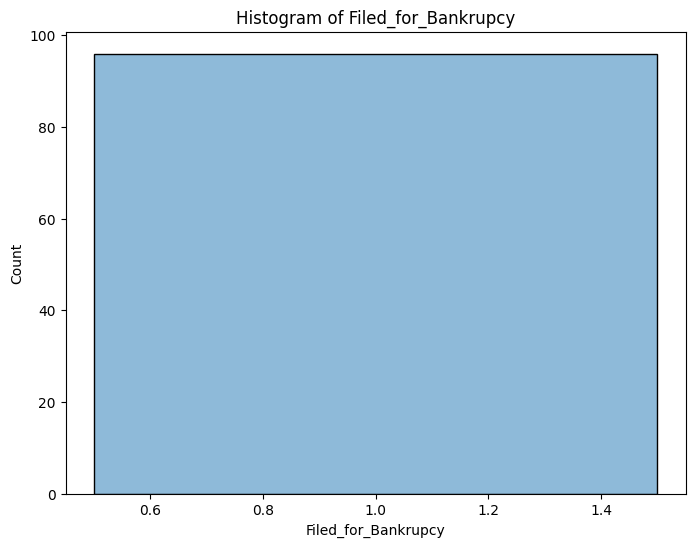

In [80]:
data_exploration(df9, 'Filed_for_Bankrupcy') # This is a list of the 97 students who have filed for bankruptcy; thus we can assume that the other (1000-97) 903 students have not.

Mean of LongTermPlannerScore: 0.70
Standard deviation of LongTermPlannerScore: 0.17
Number of outliers in LongTermPlannerScore: 8
Outliers values:
[0.20067997 0.16686285 0.22992073 0.16196331 0.19883872 0.09097842
 0.1283446  0.17022491]


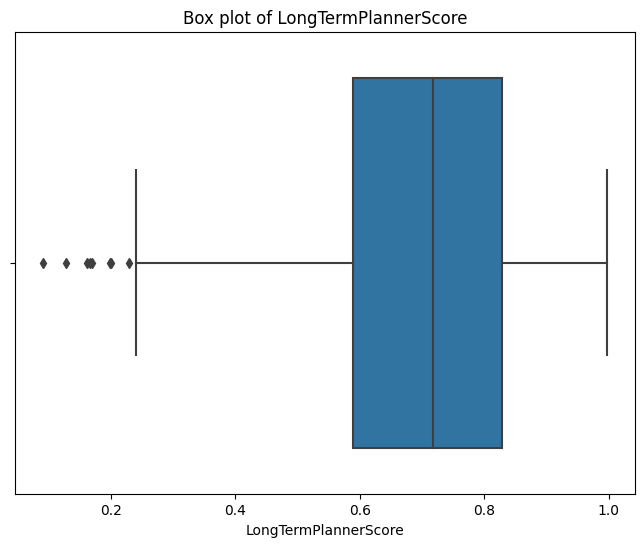

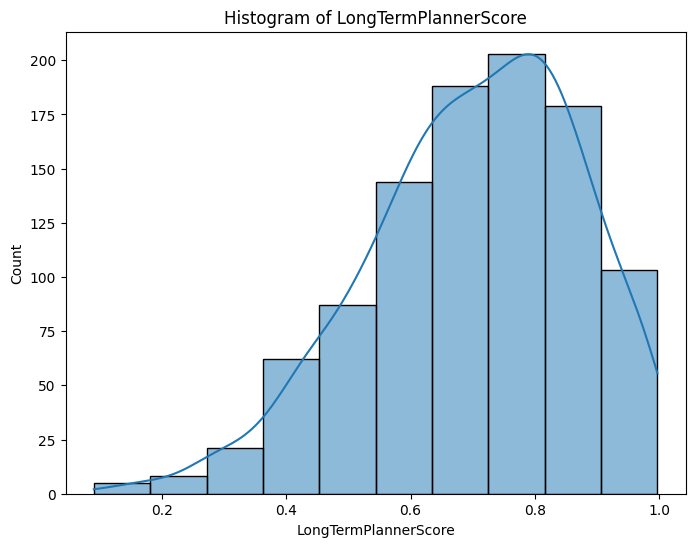

In [81]:
data_exploration(df10, 'LongTermPlannerScore') # Most students range between 0.6 and 0.8; the data is negatively skewed; there are 8 outliers

Counts and percentages of unique values in DecisionStyle:

            Count  Percentage
Emotional     914        91.4
Analytical     86         8.6


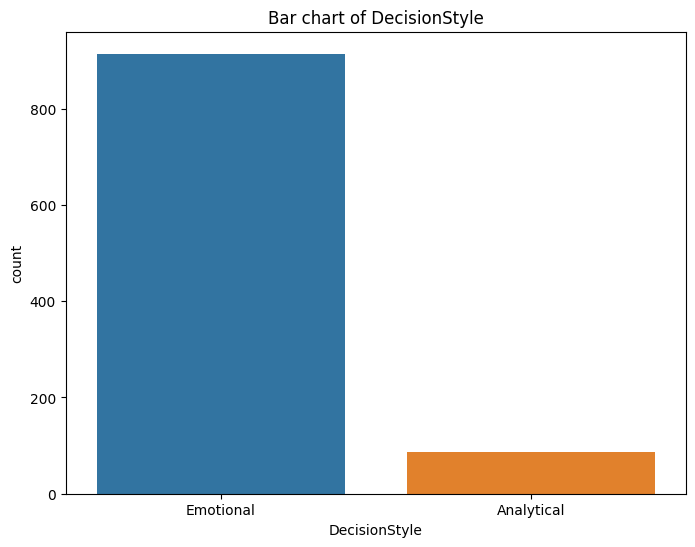

In [82]:
data_exploration(df10, 'DecisionStyle') # 91% of the students are emotional; the data is very imbalanced

Mean of PowerOrientedScore: 0.61
Standard deviation of PowerOrientedScore: 0.20
Number of outliers in PowerOrientedScore: 6
Outliers values:
[0.0791475  0.10274739 0.07839175 0.07681959 0.09174184 0.10933996]


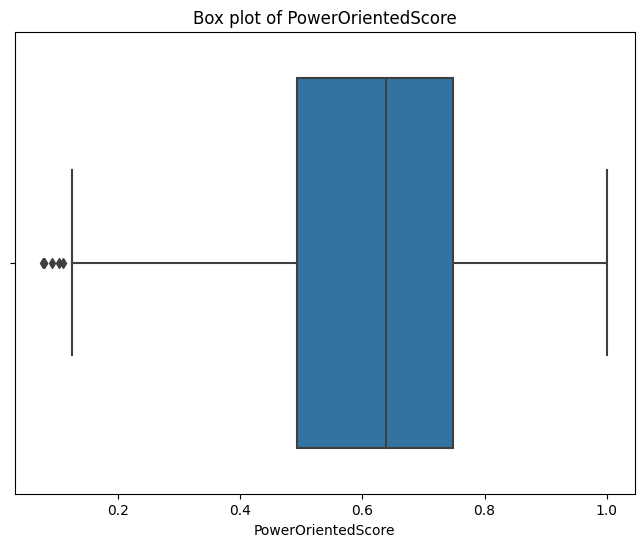

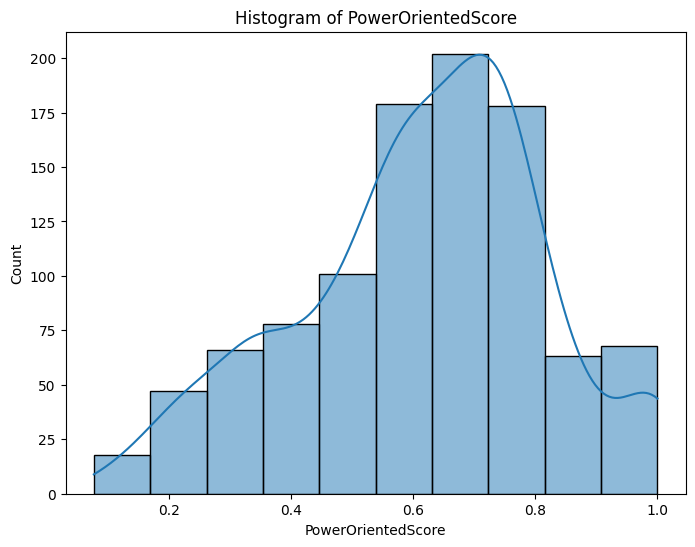

In [83]:
data_exploration(df10, 'PowerOrientedScore') # Most students fall between 0.6 and 0.8; there are 6 outliers

Mean of CommunityOrientedScore: 0.38
Standard deviation of CommunityOrientedScore: 0.21
Number of outliers in CommunityOrientedScore: 0
Outliers values:
[]


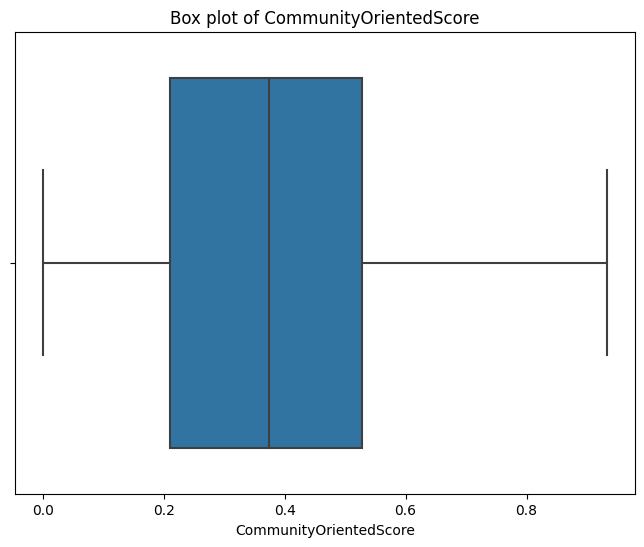

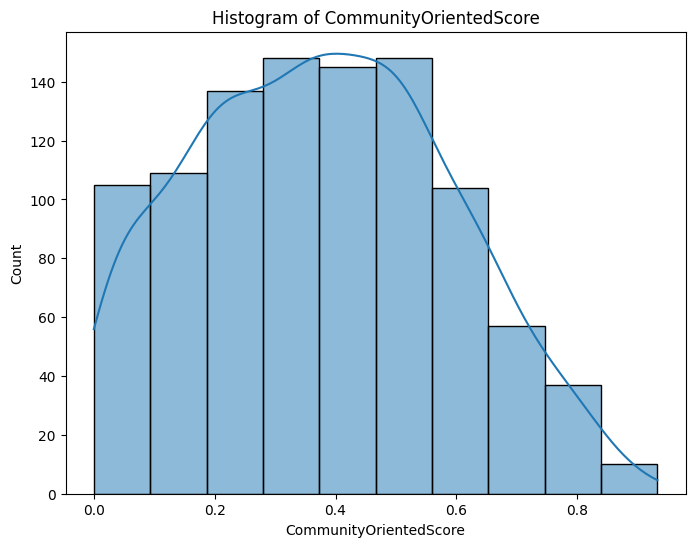

In [84]:
data_exploration(df10, 'CommunityOrientedScore') # Most students fall between 0.2 and 0.5; data is positively skewed